# imports and params

In [1]:
#https://www.kaggle.com/allunia/protein-atlas-exploration-and-baseline
#https://www.kaggle.com/allunia/in-depth-protein-correlations

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.sys.path.append('../fastai/') #fastai version 1
import fastai
from fastai import *

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import uuid

import seaborn as sns
sns.set()


DP = Path('/home/Deep_Learner/work/datasets/human-protein-atlas-image-classification/')
STAGE_ONE_DATA = DP/'stage1_data'
TRAIN_PNGS = 'train_pngs_512'
TRAIN_PNGS_MULTI = 'train_pngs_512_multi'
TEST_PNGS = 'test_pngs_512'
TRAIN_CSV = 'train.csv'
TRAIN_CSV_MULTI = 'train_multi.csv'
LBS_BALANCED = 'lbs_balanced.csv'

label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_label_names = dict((v,k) for k,v in label_names.items())

sz = 512

torch.cuda.set_device(1)

# Labels distrib.

In [22]:
train_labels = pd.read_csv(STAGE_ONE_DATA/TRAIN_CSV)
train_labels.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [4]:
def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

def get_labels_distribution(df:pd.DataFrame):
    for key in label_names.keys():
        df[label_names[key]] = 0
    df = df.apply(fill_targets, axis=1)
    target_counts = df.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
    plt.figure(figsize=(15,15))
    sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)
    return target_counts

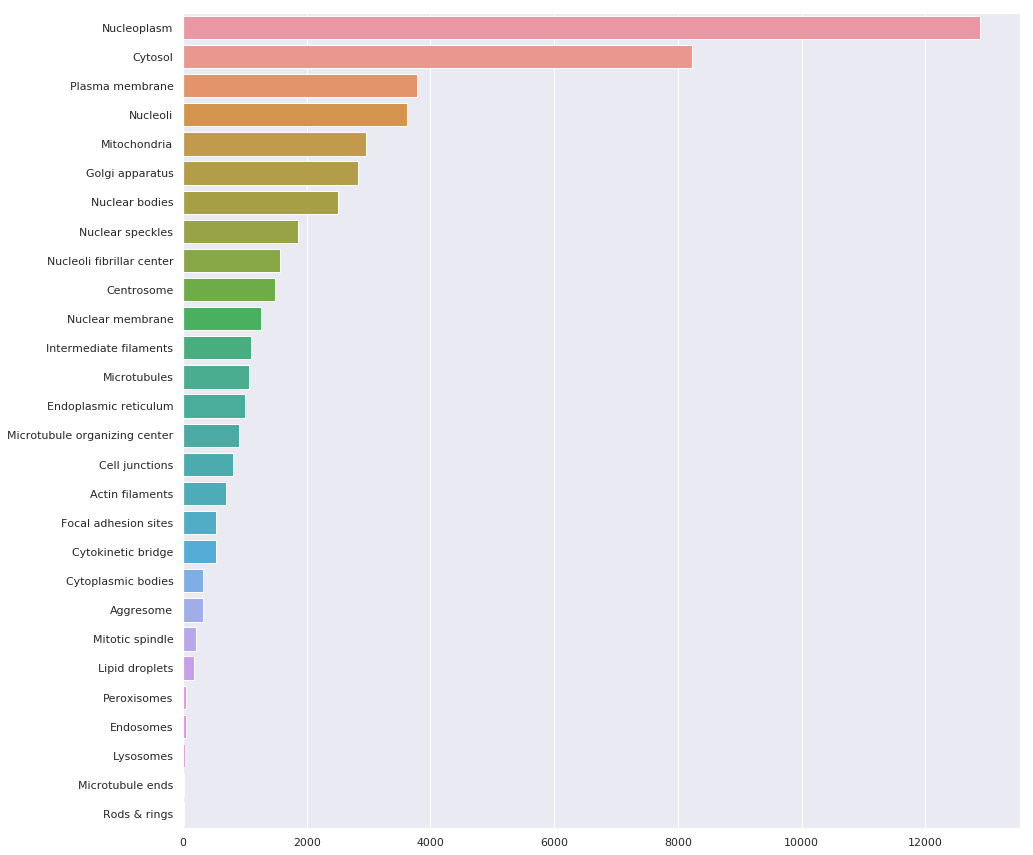

In [5]:
target_counts = get_labels_distribution(train_labels)

In [6]:
target_counts

Nucleoplasm                      12885
Cytosol                           8228
Plasma membrane                   3777
Nucleoli                          3621
Mitochondria                      2965
Golgi apparatus                   2822
Nuclear bodies                    2513
Nuclear speckles                  1858
Nucleoli fibrillar center         1561
Centrosome                        1482
Nuclear membrane                  1254
Intermediate filaments            1093
Microtubules                      1066
Endoplasmic reticulum             1008
Microtubule organizing center      902
Cell junctions                     802
Actin filaments                    688
Focal adhesion sites               537
Cytokinetic bridge                 530
Cytoplasmic bodies                 328
Aggresome                          322
Mitotic spindle                    210
Lipid droplets                     172
Peroxisomes                         53
Endosomes                           45
Lysosomes                

# multiply rare classes in df

In [147]:
lbs_balanced = pd.read_csv(STAGE_ONE_DATA/LBS_BALANCED)

In [148]:
lbs_balanced.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
def multiply_rare_classes(rare_cls:list, multi_fac:int, df:pd.DataFrame):
    for index, row in df.iterrows():
        s = str(row['Target'])
        sl = s.split(sep=' ')
        il = [int(st) for st in sl]
        ls = [label_names[l] for l in il]
        if bool(set(ls) & set(rare_cls)):
            #print('true')
            for i in range(multi_fac):
                df = df.append(row)
    return df

In [162]:
rare_classes = ['Rods & rings']
#rare_classes = ['Microtubule ends', 'Nucleoli fibrillar center', 'Centrosome', 'Rods & rings']

In [157]:
rare_classes

['Microtubule organizing center', 'Microtubules']

In [158]:
lbs_balanced = multiply_rare_classes(rare_cls=rare_classes, multi_fac=2, df = lbs_balanced)

In [159]:
t = get_labels_distribution(lbs_balanced)

In [160]:
t

Nucleoplasm                      26321
Cytosol                          14541
Nucleoli                          7162
Plasma membrane                   6788
Mitotic spindle                   6060
Nuclear membrane                  5612
Microtubule organizing center     5448
Microtubules                      5439
Intermediate filaments            5292
Nuclear bodies                    5112
Cell junctions                    4635
Cytokinetic bridge                4183
Mitochondria                      4060
Actin filaments                   3985
Golgi apparatus                   3499
Aggresome                         3352
Focal adhesion sites              3170
Cytoplasmic bodies                2880
Endosomes                         2845
Lysosomes                         2828
Nuclear speckles                  2778
Peroxisomes                       2703
Lipid droplets                    2580
Endoplasmic reticulum             2306
Rods & rings                      2211
Centrosome               

In [161]:
lbs_balanced.to_csv(STAGE_ONE_DATA/LBS_BALANCED, index=False)

# Load and save rare images with new uuid

In [35]:
def get_rare_cls_id_list(rare_cls:list, df:pd.DataFrame):
    result = []
    for index, row in df.iterrows():
        s = str(row['Target'])
        sl = s.split(sep=' ')
        il = [int(st) for st in sl]
        ls = [label_names[l] for l in il]
        if bool(set(ls) & set(rare_cls)):
            #print(row)
            result.append(row['Id'])
    return result

def open_rgby(path,id):
    """
    a function that reads RGBY image
    """
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)
    
def open_four_channels_and_save_with_new_id(load_path, load_id, save_path):
    """
    A function that reads the four images belonging to one id and saving them unchanged with a new id.
    
    #Arguments:
        load_path: folder_path
        load_id: id without the color suffix
        save_path: folder_path
    
    #Returns:
        The new new Id as a string.
    """
    new_id = str(uuid.uuid4())
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    imgs = [cv2.imread(os.path.join(load_path, load_id+'_'+color+'.png'), flags)
           for color in colors]
    for img, col in zip(imgs, colors):
        cv2.imwrite(f'{save_path}/{new_id}_{col}.png', img)
    return new_id, imgs

def display_img_gray(img):
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.show()
    
def display_img_col(img):
    pass

In [31]:
new_id, imgs = open_four_channels_and_save_with_new_id(load_path=STAGE_ONE_DATA/TRAIN_PNGS, 
                                               save_path=STAGE_ONE_DATA/TRAIN_PNGS_MULTI, 
                                               load_id='05d32f36-bba3-11e8-b2b9-ac1f6b6435d0')

In [32]:
new_id

'2e867bd2-066a-42ae-9be6-db4c21c2236c'

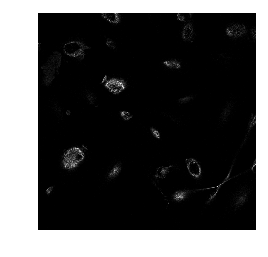

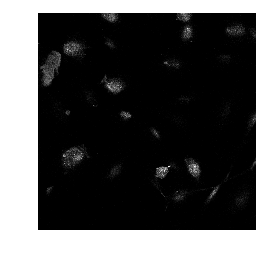

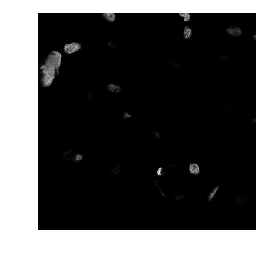

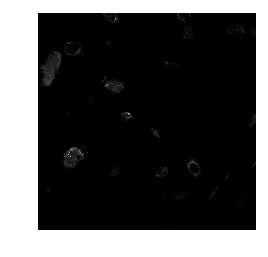

In [38]:
for img in imgs:
    display_img_gray(img)

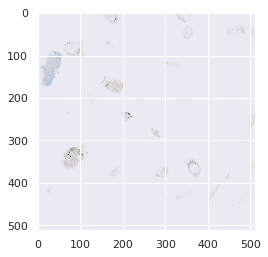

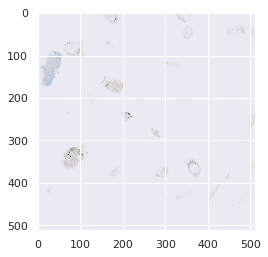

In [37]:
img1 = open_rgby(path=STAGE_ONE_DATA/TRAIN_PNGS, 
                 id='05d32f36-bba3-11e8-b2b9-ac1f6b6435d0')
img2 = open_rgby(path=STAGE_ONE_DATA/TRAIN_PNGS_MULTI,
                 id=new_id)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

In [23]:
rare_classes = ['Rods & rings']
result = get_rare_cls_id_list(rare_cls=rare_classes, df=train_labels);result

['05d32f36-bba3-11e8-b2b9-ac1f6b6435d0',
 '082a828a-bbbb-11e8-b2ba-ac1f6b6435d0',
 '0afda11a-bba0-11e8-b2b9-ac1f6b6435d0',
 '18df69fc-bbb5-11e8-b2ba-ac1f6b6435d0',
 '2b3ce424-bba8-11e8-b2ba-ac1f6b6435d0',
 '43f6bd88-bbc5-11e8-b2bc-ac1f6b6435d0',
 '70b97ed2-bbac-11e8-b2ba-ac1f6b6435d0',
 '802998d4-bbbb-11e8-b2ba-ac1f6b6435d0',
 'b1131086-bb9f-11e8-b2b9-ac1f6b6435d0',
 'c9806c74-bbca-11e8-b2bc-ac1f6b6435d0',
 'e403806e-bbbf-11e8-b2bb-ac1f6b6435d0']

In [ ]:
for i in result:
    open_four_channels_and_save_with_new_id